In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer  # Aktifkan fitur eksperimen
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import make_scorer, classification_report, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import pickle
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/preeclampsi(1)(1).csv")
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        839 non-null    float64
 1   IMT        842 non-null    float64
 2   Sistol     842 non-null    int64  
 3   Diastol    842 non-null    int64  
 4   HR         842 non-null    int64  
 5   RR         842 non-null    int64  
 6   SpO2       842 non-null    int64  
 7   Temp       842 non-null    float64
 8   Gravida    841 non-null    float64
 9   Paritas    841 non-null    float64
 10  Abortus    841 non-null    float64
 11  Glucose    838 non-null    float64
 12  Hb         842 non-null    float64
 13  Tromb      842 non-null    int64  
 14  ProtUrin   842 non-null    int64  
 15  riw_HT     842 non-null    int64  
 16  UK         842 non-null    int64  
 17  jml_janin  842 non-null    int64  
 18  DM         842 non-null    int64  
 19  Level      842 non-null    object 
dtypes: float64

(    age        IMT  Sistol  Diastol   HR  RR  SpO2  Temp  Gravida  Paritas  \
 0  26.0  25.477447     154       98  112  20    98  36.3      1.0      0.0   
 1  35.0  33.622088     150      100   94  20    99  36.5      2.0      1.0   
 2  30.0  27.983235     145       89   93  20    98  36.6      2.0      1.0   
 3  36.0  30.093652     175      102  101  20    99  36.2      2.0      1.0   
 4  36.0  30.239334     173      107  101  20    98  36.5      2.0      1.0   
 
    Abortus  Glucose    Hb  Tromb  ProtUrin  riw_HT  UK  jml_janin  DM   Level  
 0      0.0     75.0  11.7     34         2       0  24          1   0  severe  
 1      0.0     94.0  13.3     78         0       1  39          1   0    mild  
 2      0.0     88.0  13.3     80         3       0  35          1   0  severe  
 3      0.0    107.0   8.2     85         3       0  28          1   0  severe  
 4      0.0    183.0  10.5     87         3       0  30          1   0  severe  ,
 None)

In [4]:
print(df['Level'].unique())

['severe' 'mild' 'normal']


In [5]:
# ==== Load Data ====
# df = pd.read_csv("your_data.csv")
X = df.drop(columns=["Level"])
y = df["Level"]

In [6]:
# 2. Label Encoding
level_mapping = {
    'normal': 0,
    'mild': 1,
    'severe': 2
}
# Apply the mapping to the 'Level' column
df['Level'] = df['Level'].map(level_mapping)

print(df['Level'].value_counts())

Level
0    499
2    205
1    138
Name: count, dtype: int64


In [7]:
# Sample preprocessing for example only
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [8]:
# Cek hasil
print("Shape X_trainval:", X_trainval.shape)
print("Shape X_test:", X_test.shape)
print("Label encoded classes:", y.unique())

Shape X_trainval: (673, 19)
Shape X_test: (169, 19)
Label encoded classes: ['severe' 'mild' 'normal']


In [9]:
# === CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Model list
models = {
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'GB': GradientBoostingClassifier(random_state=42),
    'LGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'LR': LogisticRegression(max_iter=1000, random_state=42)
}

In [10]:
# === Scoring Metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'mcc': make_scorer(matthews_corrcoef),
    'roc_auc_ovr': make_scorer(roc_auc_score, multi_class='ovr', average='macro', response_method="predict_proba")
}

In [11]:
# === Training loop for each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")

    pipeline = ImbPipeline([
        ('imputer', IterativeImputer(random_state=42)),
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('select', SelectKBest(mutual_info_classif, k='all')),  # Filter MI > 0 handled below
        ('clf', model)
    ])

    # Fit pipeline once to get MI scores
    X_imp = IterativeImputer(random_state=42).fit_transform(X_trainval)
    mi_scores = mutual_info_classif(X_imp, y_trainval)
    selected_idx = np.where(mi_scores > 0)[0]

    # Final pipeline with selected features
    pipeline.steps[3] = ('select', SelectKBest(mutual_info_classif, k=len(selected_idx)))

    # Cross-validation
    # Jangan slice fitur manual — biarkan pipeline yang handle
    cv_result = cross_validate(pipeline, X_trainval, y_trainval, cv=cv, scoring=scoring)
    results[name] = {metric: np.mean(cv_result[f'test_{metric}']) for metric in scoring.keys()}

    # Train final model for saving
    pipeline.fit(X_trainval, y_trainval)
    with open(f"{name}.sav", "wb") as f:
        pickle.dump(pipeline, f)

print("✅ Semua model tunggal selesai dilatih dan disimpan.")

# Iterate and display the evaluation scores for each model
print("\n=== Model Evaluation Results ===")
for name, scores in results.items():
    print(f"\n--- {name} ---")
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")

Training SVM...
Training KNN...
Training DT...
Training RF...
Training GB...
Training LGBM...
Training LR...
✅ Semua model tunggal selesai dilatih dan disimpan.

=== Model Evaluation Results ===

--- SVM ---
accuracy: 0.9168
precision_macro: 0.8661
recall_macro: 0.8603
f1_macro: 0.8601
balanced_accuracy: 0.8603
mcc: 0.8536
roc_auc_ovr: 0.9741

--- KNN ---
accuracy: 0.8930
precision_macro: 0.8313
recall_macro: 0.8379
f1_macro: 0.8304
balanced_accuracy: 0.8379
mcc: 0.8130
roc_auc_ovr: 0.9440

--- DT ---
accuracy: 0.8708
precision_macro: 0.7906
recall_macro: 0.7820
f1_macro: 0.7818
balanced_accuracy: 0.7820
mcc: 0.7717
roc_auc_ovr: 0.8624

--- RF ---
accuracy: 0.9138
precision_macro: 0.8629
recall_macro: 0.8568
f1_macro: 0.8556
balanced_accuracy: 0.8568
mcc: 0.8479
roc_auc_ovr: 0.9780

--- GB ---
accuracy: 0.9139
precision_macro: 0.8617
recall_macro: 0.8555
f1_macro: 0.8544
balanced_accuracy: 0.8555
mcc: 0.8484
roc_auc_ovr: 0.9779

--- LGBM ---
accuracy: 0.9064
precision_macro: 0.8476
rec

In [13]:
# prompt: print feature

X.columns

Index(['age', 'IMT', 'Sistol', 'Diastol', 'HR', 'RR', 'SpO2', 'Temp',
       'Gravida', 'Paritas', 'Abortus', 'Glucose', 'Hb', 'Tromb', 'ProtUrin',
       'riw_HT', 'UK', 'jml_janin', 'DM'],
      dtype='object')

In [14]:
import joblib

# Load the model
model_path = "/content/stacking_tuned_LGBM_v2.sav"
model = joblib.load(model_path)

# Check the pipeline steps and expected input features
model_steps = model.named_steps
model_steps


{'imputer': IterativeImputer(random_state=42),
 'smote': SMOTE(random_state=42),
 'scaler': StandardScaler(),
 'select': SelectKBest(k=19, score_func=<function mutual_info_classif at 0x7a96081c5940>),
 'stacking': StackingClassifier(cv=5,
                    estimators=[('svm', SVC(probability=True)),
                                ('rf', RandomForestClassifier()),
                                ('gb', GradientBoostingClassifier()),
                                ('lgbm', LGBMClassifier())],
                    final_estimator=LGBMClassifier(), n_jobs=-1)}

In [15]:
features = model.named_steps['imputer'].feature_names_in_
print(features)


['age' 'IMT' 'Sistol' 'Diastol' 'HR' 'RR' 'SpO2' 'Temp' 'Gravida'
 'Paritas' 'Abortus' 'Glucose' 'Hb' 'Tromb' 'ProtUrin' 'riw_HT' 'UK'
 'jml_janin' 'DM']


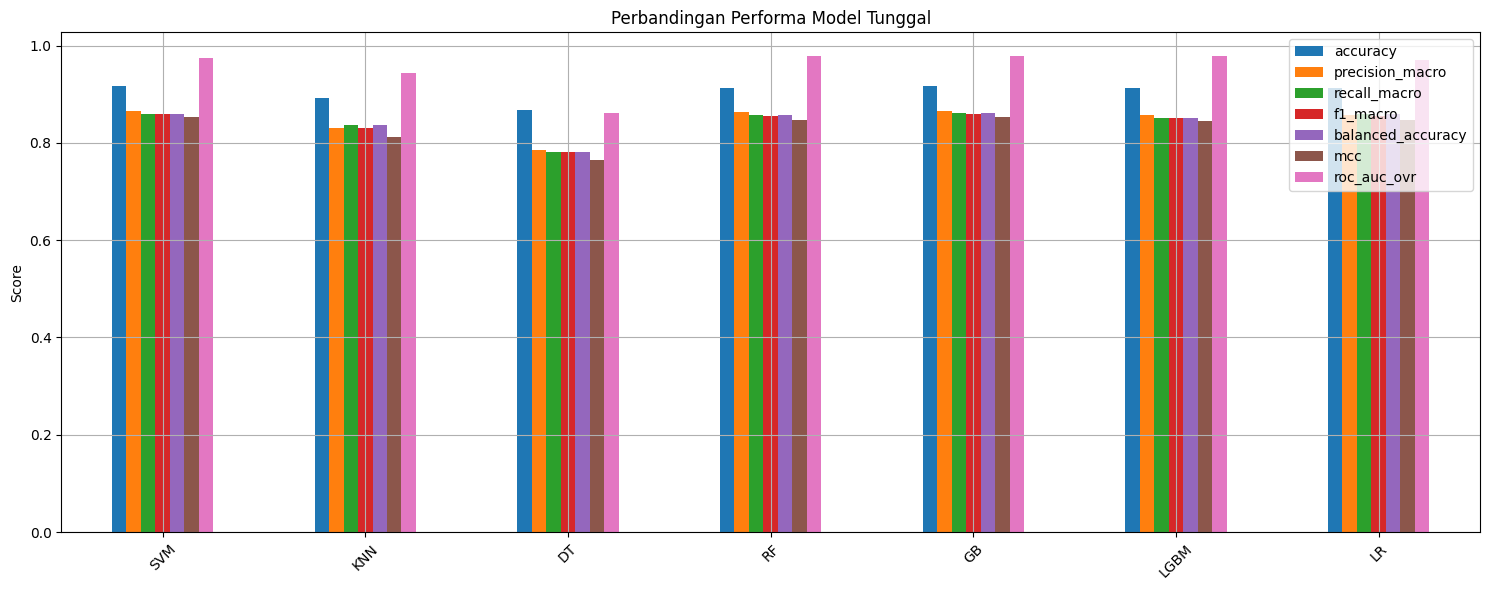

In [ ]:
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results).T
df_results.plot(kind='bar', figsize=(15, 6))
plt.title("Perbandingan Performa Model Tunggal")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(True)
plt.show()


tuning single model

In [ ]:
from sklearn.model_selection import GridSearchCV

# === Definisi parameter grid untuk setiap model
param_grids = {
    'SVM': {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    },
    'KNN': {
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    },
    'DT': {
        'clf__max_depth': [3, 5, 10],
        'clf__criterion': ['gini', 'entropy']
    },
    'RF': {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [5, 10]
    },
    'GB': {
        'clf__n_estimators': [50, 100],
        'clf__learning_rate': [0.05, 0.1]
    },
    'LGBM': {
        'clf__n_estimators': [50, 100],
        'clf__learning_rate': [0.05, 0.1]
    },
    'LR': {
        'clf__C': [0.01, 0.1, 1],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    }
}

# === Dictionary untuk menyimpan best params dan evaluasi
tuned_results = {}
best_params = {}

# === Loop tuning
for name, model in models.items():
    print(f"🔍 Tuning {name}...")

    pipeline = ImbPipeline([
    ('imputer', IterativeImputer(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('select', SelectKBest(mutual_info_classif, k=len(selected_idx))),
    ('clf', model)
])

    # Fit awal untuk MI selection
    X_imp = IterativeImputer(random_state=42).fit_transform(X_trainval)
    mi_scores = mutual_info_classif(X_imp, y_trainval)
    selected_idx = np.where(mi_scores > 0)[0]
    k_mi = len(selected_idx)

    pipeline.steps[3] = ('select', SelectKBest(mutual_info_classif, k=k_mi))

    grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grids[name],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',  # atau scoring lain sesuai fokus evaluasi
    n_jobs=-1,
    verbose=1
    )

    grid.fit(X_trainval, y_trainval)

    best_model = grid.best_estimator_
    best_score = grid.best_score_

    # Save best params and model
    pd.DataFrame(grid.best_params_, index=[0]).to_csv(f"{name}_best_params.csv", index=False)
    with open(f"{name}_tuned.sav", "wb") as f:
      pickle.dump(grid.best_estimator_, f)

    # Evaluate
    scores = cross_validate(best_model, X_trainval, y_trainval, cv=cv, scoring=scoring)
    tuned_results[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

print("✅ Tuning selesai untuk semua model. Model dan parameter terbaik telah disimpan.")


🔍 Tuning SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
🔍 Tuning KNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
🔍 Tuning DT...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
🔍 Tuning RF...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
🔍 Tuning GB...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
🔍 Tuning LGBM...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
🔍 Tuning LR...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Tuning selesai untuk semua model. Model dan parameter terbaik telah disimpan.


In [ ]:
# Simpan parameter terbaik
#df_params = pd.DataFrame(best_params).T
#df_params.to_csv("best_params_gridsearch.csv")
#print("📝 Best parameters disimpan sebagai best_params_gridsearch.csv")


📝 Best parameters disimpan sebagai best_params_gridsearch.csv



=== Tuned Model Evaluation Results ===

--- SVM (Tuned) ---
accuracy: 0.9168
precision_macro: 0.8661
recall_macro: 0.8603
f1_macro: 0.8601
balanced_accuracy: 0.8603
mcc: 0.8536
roc_auc_ovr: 0.9741

--- KNN (Tuned) ---
accuracy: 0.8960
precision_macro: 0.8358
recall_macro: 0.8398
f1_macro: 0.8342
balanced_accuracy: 0.8398
mcc: 0.8176
roc_auc_ovr: 0.9350

--- DT (Tuned) ---
accuracy: 0.8945
precision_macro: 0.8354
recall_macro: 0.8376
f1_macro: 0.8296
balanced_accuracy: 0.8376
mcc: 0.8170
roc_auc_ovr: 0.9545

--- RF (Tuned) ---
accuracy: 0.9183
precision_macro: 0.8674
recall_macro: 0.8639
f1_macro: 0.8635
balanced_accuracy: 0.8639
mcc: 0.8555
roc_auc_ovr: 0.9769

--- GB (Tuned) ---
accuracy: 0.9183
precision_macro: 0.8668
recall_macro: 0.8656
f1_macro: 0.8639
balanced_accuracy: 0.8656
mcc: 0.8559
roc_auc_ovr: 0.9790

--- LGBM (Tuned) ---
accuracy: 0.9123
precision_macro: 0.8583
recall_macro: 0.8514
f1_macro: 0.8514
balanced_accuracy: 0.8514
mcc: 0.8451
roc_auc_ovr: 0.9782

--- LR (Tuned

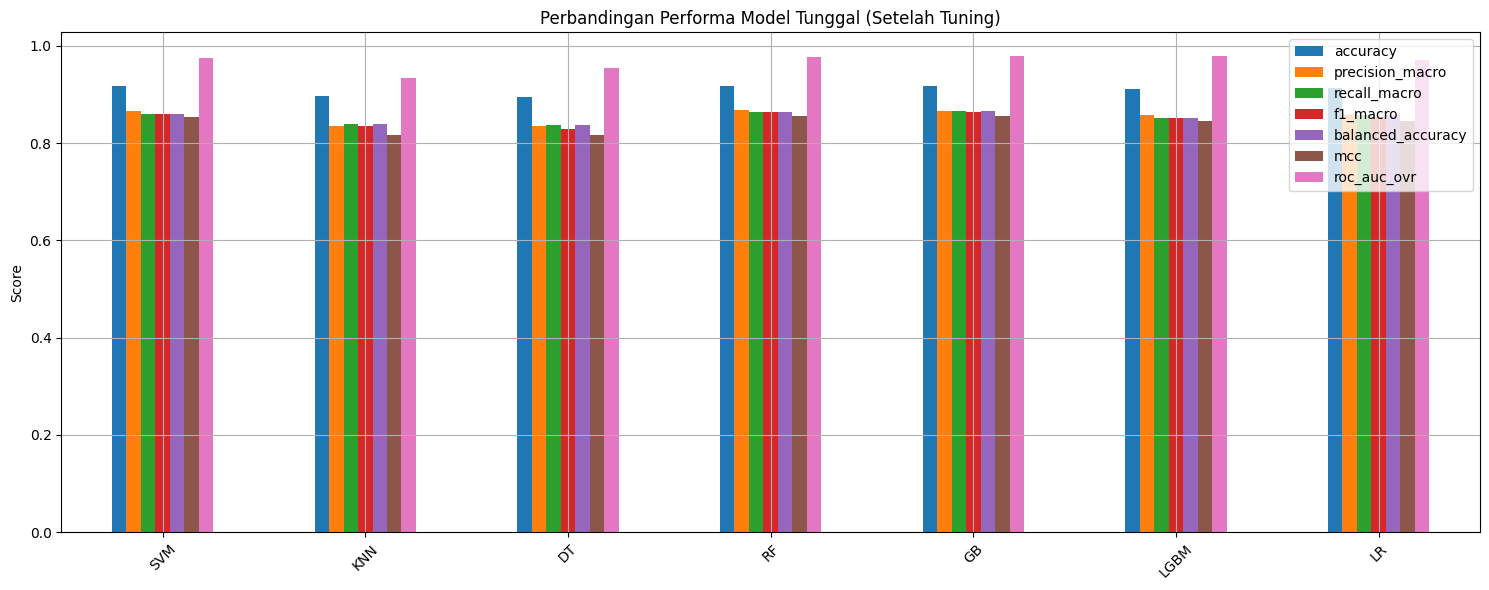

In [ ]:
# Iterate and display the evaluation scores for each model after tuning
print("\n=== Tuned Model Evaluation Results ===")
for name, scores in tuned_results.items():
    print(f"\n--- {name} (Tuned) ---")
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")

df_tuned_results = pd.DataFrame(tuned_results).T
df_tuned_results.plot(kind='bar', figsize=(15, 6))
plt.title("Perbandingan Performa Model Tunggal (Setelah Tuning)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(True)
plt.show()

## Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.base import clone

stacking_configs = {
    "Stacking_1": KNeighborsClassifier(),
    "Stacking_2": SVC(probability=True),
    "Stacking_3": DecisionTreeClassifier(),
    "Stacking_4": RandomForestClassifier(),
    "Stacking_5": GradientBoostingClassifier(),
    "Stacking_6": lgb.LGBMClassifier(),
    "Stacking_7": LogisticRegression(max_iter=1000),
    "Stacking_11": KNeighborsClassifier(),
    "Stacking_12": SVC(probability=True),
    "Stacking_13": DecisionTreeClassifier(),
    "Stacking_14": RandomForestClassifier(),
    "Stacking_15": GradientBoostingClassifier(),
    "Stacking_16": lgb.LGBMClassifier(verbose=-1),
    "Stacking_17": LogisticRegression(max_iter=1000)
}

base_7 = [
    ('knn', KNeighborsClassifier()),
    ('svm', SVC(probability=True)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('lgbm', lgb.LGBMClassifier(verbose=-1)),
    ('lr', LogisticRegression(max_iter=1000))
]

base_3 = [
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier()),
    ('lgbm', lgb.LGBMClassifier(verbose=-1))
]

stacking_results = {}

for name, meta in stacking_configs.items():
    print(f"🔧 Training {name}...")
    base = base_7 if name.split("_")[1] in ['1','2','3','4','5','6','7'] else base_3

    stacking_clf = StackingClassifier(
        estimators=[(m[0], clone(m[1])) for m in base],
        final_estimator=clone(meta),
        cv=5,
        n_jobs=-1,
        passthrough=False
    )

    pipeline = ImbPipeline([
        ('imputer', IterativeImputer(random_state=42)),
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('select', SelectKBest(mutual_info_classif, k='all')),
        ('stack', stacking_clf)
    ])

    # Mutual info filtering
    X_imp = IterativeImputer(random_state=42).fit_transform(X_trainval)
    mi_scores = mutual_info_classif(X_imp, y_trainval)
    selected_idx = np.where(mi_scores > 0)[0]
    pipeline.steps[3] = ('select', SelectKBest(mutual_info_classif, k=len(selected_idx)))

    # Cross validation evaluation
    score = cross_validate(pipeline, X_trainval.iloc[:, selected_idx], y_trainval, cv=cv, scoring=scoring)
    stacking_results[name] = {metric: np.mean(score[f'test_{metric}']) for metric in scoring.keys()}

    # Fit dan simpan
    pipeline.fit(X_trainval.iloc[:, selected_idx], y_trainval)
    with open(f"{name}.sav", "wb") as f:
        pickle.dump(pipeline, f)

print("✅ Semua model stacking selesai dilatih & disimpan.")

# Iterate and display the evaluation scores for each stacking model
print("\n=== Stacking Model Evaluation Results ===")
for name, scores in stacking_results.items():
    print(f"\n--- {name} ---")
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")

df_stack = pd.DataFrame(stacking_results).T
df_stack_sorted = df_stack.sort_values(by='f1_macro', ascending=False)
display(df_stack_sorted)



🔧 Training Stacking_1...
🔧 Training Stacking_2...
🔧 Training Stacking_3...
🔧 Training Stacking_4...
🔧 Training Stacking_5...
🔧 Training Stacking_6...
🔧 Training Stacking_7...
🔧 Training Stacking_11...
🔧 Training Stacking_12...
🔧 Training Stacking_13...
🔧 Training Stacking_14...
🔧 Training Stacking_15...
🔧 Training Stacking_16...
🔧 Training Stacking_17...
✅ Semua model stacking selesai dilatih & disimpan.

=== Stacking Model Evaluation Results ===

--- Stacking_1 ---
accuracy: 0.9094
precision_macro: 0.8537
recall_macro: 0.8445
f1_macro: 0.8454
balanced_accuracy: 0.8445
mcc: 0.8399
roc_auc_ovr: 0.9412

--- Stacking_2 ---
accuracy: 0.9094
precision_macro: 0.8560
recall_macro: 0.8456
f1_macro: 0.8459
balanced_accuracy: 0.8456
mcc: 0.8400
roc_auc_ovr: 0.9733

--- Stacking_3 ---
accuracy: 0.9183
precision_macro: 0.8679
recall_macro: 0.8635
f1_macro: 0.8636
balanced_accuracy: 0.8635
mcc: 0.8552
roc_auc_ovr: 0.9135

--- Stacking_4 ---
accuracy: 0.9183
precision_macro: 0.8704
recall_macro: 0.8

,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy,mcc,roc_auc_ovr
Stacking_7,0.924234,0.879565,0.870934,0.871942,0.870934,0.866066,0.983055
Stacking_5,0.922753,0.876764,0.870871,0.869754,0.870871,0.863826,0.977786
Stacking_3,0.918308,0.867892,0.863497,0.863609,0.863497,0.855187,0.913508
Stacking_4,0.918286,0.870409,0.862727,0.861791,0.862727,0.855823,0.975071
Stacking_6,0.919790,0.880534,0.862790,0.861394,0.862790,0.859987,0.974545
Stacking_11,0.918308,0.869603,0.859583,0.860499,0.859583,0.855761,0.942633
Stacking_17,0.918308,0.869169,0.859583,0.860483,0.859583,0.855672,0.980402
Stacking_16,0.918297,0.878487,0.855606,0.857710,0.855606,0.856984,0.973458
Stacking_14,0.913820,0.859642,0.852513,0.853709,0.852513,0.847270,0.964242
Stacking_12,0.913831,0.863017,0.851503,0.852805,0.851503,0.847839,0.964144


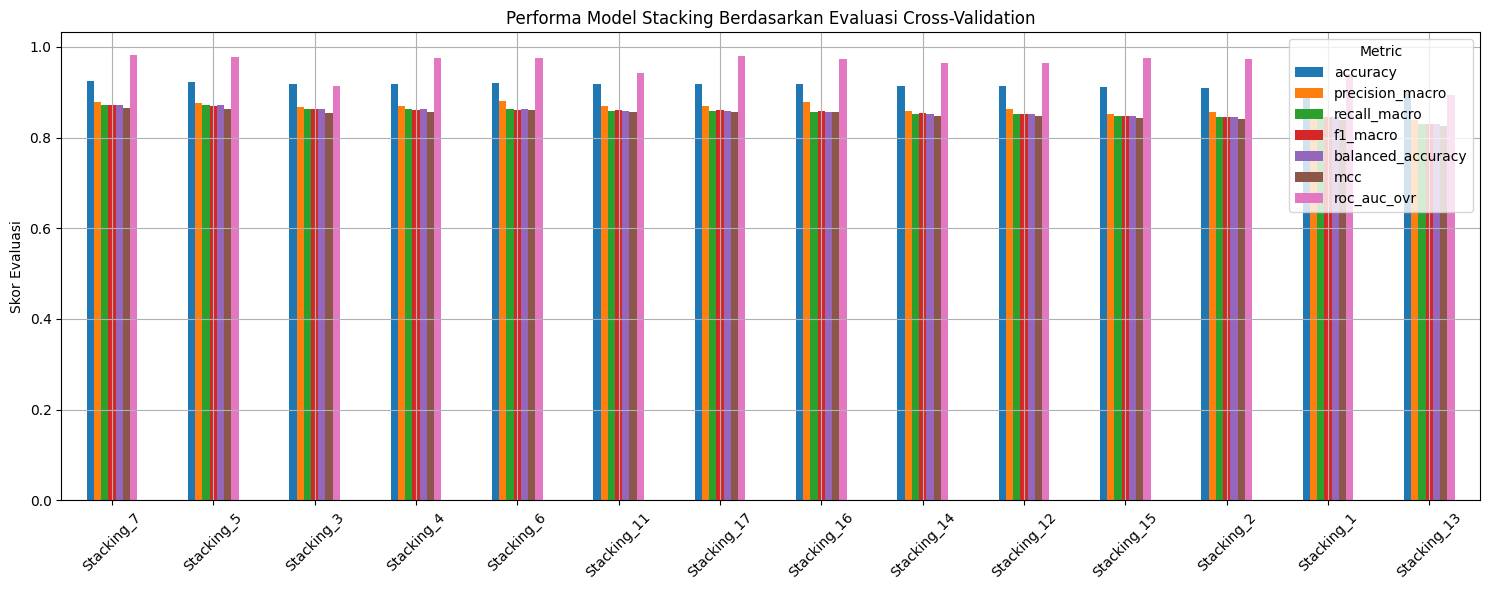

In [ ]:
# Buat DataFrame dari hasil evaluasi
df_stack = pd.DataFrame(stacking_results).T

# (Opsional) Urutkan berdasarkan salah satu metrik, misalnya f1_macro
df_stack_sorted = df_stack.sort_values(by='f1_macro', ascending=False)

# Plot
df_stack_sorted.plot(kind='bar', figsize=(15, 6))
plt.title("Performa Model Stacking Berdasarkan Evaluasi Cross-Validation")
plt.ylabel("Skor Evaluasi")
plt.xticks(rotation=45)
plt.legend(loc='upper right', title='Metric')
plt.grid(True)
plt.tight_layout()
plt.show()



🔧 Tuning Stacking Model (Meta: KNN)...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Tuning Selesai: KNN | Model & Params disimpan.

🔧 Tuning Stacking Model (Meta: SVM)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Tuning Selesai: SVM | Model & Params disimpan.

🔧 Tuning Stacking Model (Meta: DT)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Tuning Selesai: DT | Model & Params disimpan.

🔧 Tuning Stacking Model (Meta: RF)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Tuning Selesai: RF | Model & Params disimpan.

🔧 Tuning Stacking Model (Meta: GB)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Tuning Selesai: GB | Model & Params disimpan.

🔧 Tuning Stacking Model (Meta: LGBM)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Tuning Selesai: LGBM | Model & Params disimpan.

🔧 Tuning Stacking Model (Meta: LR)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Tuning Se

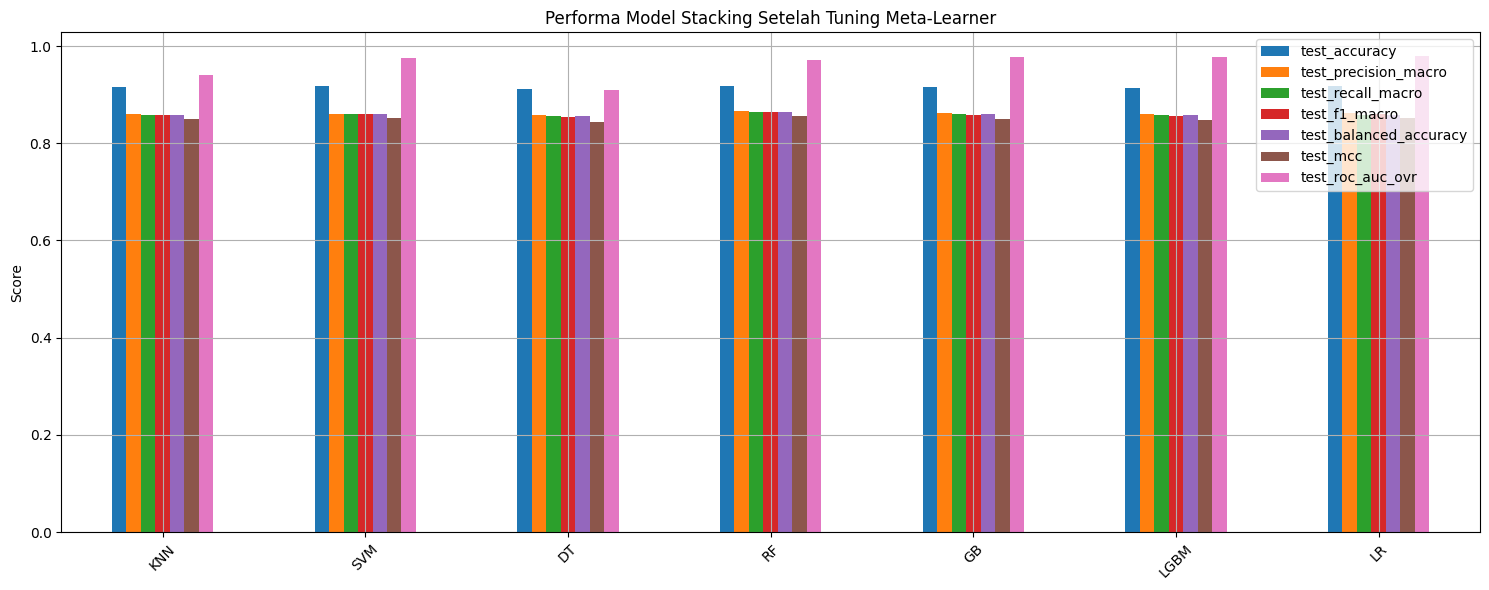

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import csv
import os

meta_param_grids = {
    'KNN': {
        'stacking__final_estimator__n_neighbors': [3, 5, 7]
    },
    'SVM': {
         'stacking__final_estimator__C': [0.1, 1],
         'stacking__final_estimator__kernel': ['rbf', 'linear']
    },
    'DT': {
        'stacking__final_estimator__max_depth': [None, 10, 20],
        'stacking__final_estimator__min_samples_split': [2, 5]
    },
    'RF': {
        'stacking__final_estimator__n_estimators': [100, 200],
        'stacking__final_estimator__max_depth': [None, 10]
    },
    'GB': {
        'stacking__final_estimator__n_estimators': [100, 200],
        'stacking__final_estimator__learning_rate': [0.05, 0.1]
    },
    'LGBM': {
        'stacking__final_estimator__n_estimators': [100, 200],
        'stacking__final_estimator__learning_rate': [0.05, 0.1],
        'stacking__final_estimator__num_leaves': [31, 50]
    },
    'LR': {
        'stacking__final_estimator__C': [0.1, 1],
        'stacking__final_estimator__solver': ['liblinear', 'lbfgs']
    }
}

# Inisialisasi ulang base estimators
base_estimators = [
    ('knn', KNeighborsClassifier()),
    ('svm', SVC(probability=True)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('lgbm', lgb.LGBMClassifier()),
    ('lr', LogisticRegression(max_iter=1000))
]

# Dictionary meta learners
meta_learners = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DT': DecisionTreeClassifier(),
    'RF': RandomForestClassifier(),
    'GB': GradientBoostingClassifier(),
    'LGBM': lgb.LGBMClassifier(),
    'LR': LogisticRegression(max_iter=1000)
}

# Simpan hasil
tuned_stacking_models = {}
tuned_stacking_params = {}

# Buat folder simpan model
os.makedirs("stacking_models", exist_ok=True)

for name, meta in meta_learners.items():
    print(f"\n🔧 Tuning Stacking Model (Meta: {name})...")

    # Buat StackingClassifier
    stacking = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta,
        cv=5,
        n_jobs=-1
    )

    # Pipeline
    pipeline = ImbPipeline([
        ('imputer', IterativeImputer(random_state=42)),
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('select', SelectKBest(mutual_info_classif, k=X_trainval.shape[1])),
        ('stacking', stacking)
    ])

    # Param grid untuk meta-learner ini
    param_grid = meta_param_grids[name]

    # GridSearchCV
    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_trainval, y_trainval)

    # Simpan model dan param
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    tuned_stacking_models[name] = best_model
    tuned_stacking_params[name] = best_params

    # Save model
    model_filename = f"stacking_models/stacking_tuned_{name}.sav"
    with open(model_filename, "wb") as f:
        pickle.dump(best_model, f)

    # Save best params
    params_filename = f"stacking_models/stacking_tuned_{name}_params.csv"
    with open(params_filename, "w", newline='') as f:
        writer = csv.writer(f)
        for key, val in best_params.items():
            writer.writerow([key, val])

    print(f"✅ Tuning Selesai: {name} | Model & Params disimpan.")

print("\n✅ Semua model stacking selesai dituning dan disimpan.")

from sklearn.model_selection import cross_validate

# Evaluasi performa dari best model yang sudah di-tuning
scores = cross_validate(best_model, X_trainval, y_trainval, scoring=scoring, cv=5)
mean_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

print(f"\n📊 Cross-validation scores for {name} (tuned):")
for metric, score in mean_scores.items():
    print(f"{metric}: {score:.4f}")

df_stacked_tuned = pd.DataFrame({
    meta: cross_validate(model, X_trainval, y_trainval, scoring=scoring, cv=5)
    for meta, model in tuned_stacking_models.items()
}).applymap(lambda v: np.mean(v) if isinstance(v, np.ndarray) else v)

df_stacked_tuned.loc[[f'test_{k}' for k in scoring.keys()]].T.plot(kind='bar', figsize=(15,6))
plt.title("Performa Model Stacking Setelah Tuning Meta-Learner")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import csv
import os

# Inisialisasi ulang base estimators
base_estimators_4 = [
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('lgbm', lgb.LGBMClassifier())
]

# Dictionary meta learners
meta_learners_4 = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DT': DecisionTreeClassifier(),
    'RF': RandomForestClassifier(),
    'GB': GradientBoostingClassifier(),
    'LGBM': lgb.LGBMClassifier(),
    'LR': LogisticRegression(max_iter=1000)
}

# Simpan hasil
tuned_stacking_4_models = {}
tuned_stacking_4_params = {}

# Buat folder simpan model
os.makedirs("stacking_models", exist_ok=True)

for name, meta in meta_learners_4.items():
    print(f"\n🔧 Tuning Stacking 4 Model (Meta: {name})...")

    # Buat StackingClassifier
    stacking_4 = StackingClassifier(
        estimators=base_estimators_4,
        final_estimator=meta,
        cv=5,
        n_jobs=-1
    )

    # Pipeline
    pipeline = ImbPipeline([
        ('imputer', IterativeImputer(random_state=42)),
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('select', SelectKBest(mutual_info_classif, k=X_trainval.shape[1])),
        ('stacking', stacking_4)
    ])

    # Param grid untuk meta-learner ini
    param_grid = meta_param_grids[name]

    # GridSearchCV
    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_trainval, y_trainval)

    # Simpan model dan param
    best_model_4 = grid.best_estimator_
    best_params_4 = grid.best_params_

    tuned_stacking_4_models[name] = best_model_4
    tuned_stacking_4_params[name] = best_params_4

    # Save model
    model_filename = f"stacking_models/stacking_4_tuned_{name}.sav"
    with open(model_filename, "wb") as f:
        pickle.dump(best_model, f)

    # Save best params
    params_filename = f"stacking_models/stacking_4_tuned_{name}_params.csv"
    with open(params_filename, "w", newline='') as f:
        writer = csv.writer(f)
        for key, val in best_params.items():
            writer.writerow([key, val])

    print(f"✅ Tuning Selesai: {name} | Model & Params disimpan.")

print("\n✅ Semua model stacking 4 selesai dituning dan disimpan.")


In [ ]:
# Iterate and display the evaluation scores for each model stacking after tuning

from sklearn.base import clone # Corrected import
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
import pickle
import os
import csv

# Evaluate the tuned stacking models
tuned_stacking_4_results = {}

for name, model in tuned_stacking_4_models.items():
    print(f"📊 Evaluating Tuned Stacking 4 Model (Meta: {name})...")
    # Mutual info filtering needs to be applied consistently
    X_imp = IterativeImputer(random_state=42).fit_transform(X_trainval)
    mi_scores = mutual_info_classif(X_imp, y_trainval)
    selected_idx = np.where(mi_scores > 0)[0]

    # The pipeline saved includes the SelectKBest step with the number of features from the tuning
    # We can directly use the saved `tuned_stacking_models[name]` pipeline for evaluation

    scores = cross_validate(model, X_trainval.iloc[:, selected_idx], y_trainval, cv=cv, scoring=scoring)
    tuned_stacking_4_results[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring.keys()}

# Iterate and display the evaluation scores for each model stacking after tuning
print("\n=== Tuned Stacking 4 Model Evaluation Results ===")
for name, scores in tuned_stacking_4_results.items():
    print(f"\n--- Stacking 4 (Meta: {name}, Tuned) ---")
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")

# Plotting the results
df_tuned_stacking_4 = pd.DataFrame(tuned_stacking_4_results).T
df_tuned_stacking_4.plot(kind='bar', figsize=(15, 6))
plt.title("Performa Model Stacking 4 (Setelah Tuning Meta-Learner)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n✅ Evaluation of tuned stacking 4 models complete.")


🔧 Tuning Stacking Versi 2 (Meta: KNN)...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Tuning Stacking V2 Selesai: KNN | Model & Params disimpan.

🔧 Tuning Stacking Versi 2 (Meta: SVM)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Tuning Stacking V2 Selesai: SVM | Model & Params disimpan.

🔧 Tuning Stacking Versi 2 (Meta: DT)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Tuning Stacking V2 Selesai: DT | Model & Params disimpan.

🔧 Tuning Stacking Versi 2 (Meta: RF)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Tuning Stacking V2 Selesai: RF | Model & Params disimpan.

🔧 Tuning Stacking Versi 2 (Meta: GB)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Tuning Stacking V2 Selesai: GB | Model & Params disimpan.

🔧 Tuning Stacking Versi 2 (Meta: LGBM)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Tuning Stacking V2 Selesai: LGBM | Model & Params disimpan.

🔧 Tuning Stacking Versi 2

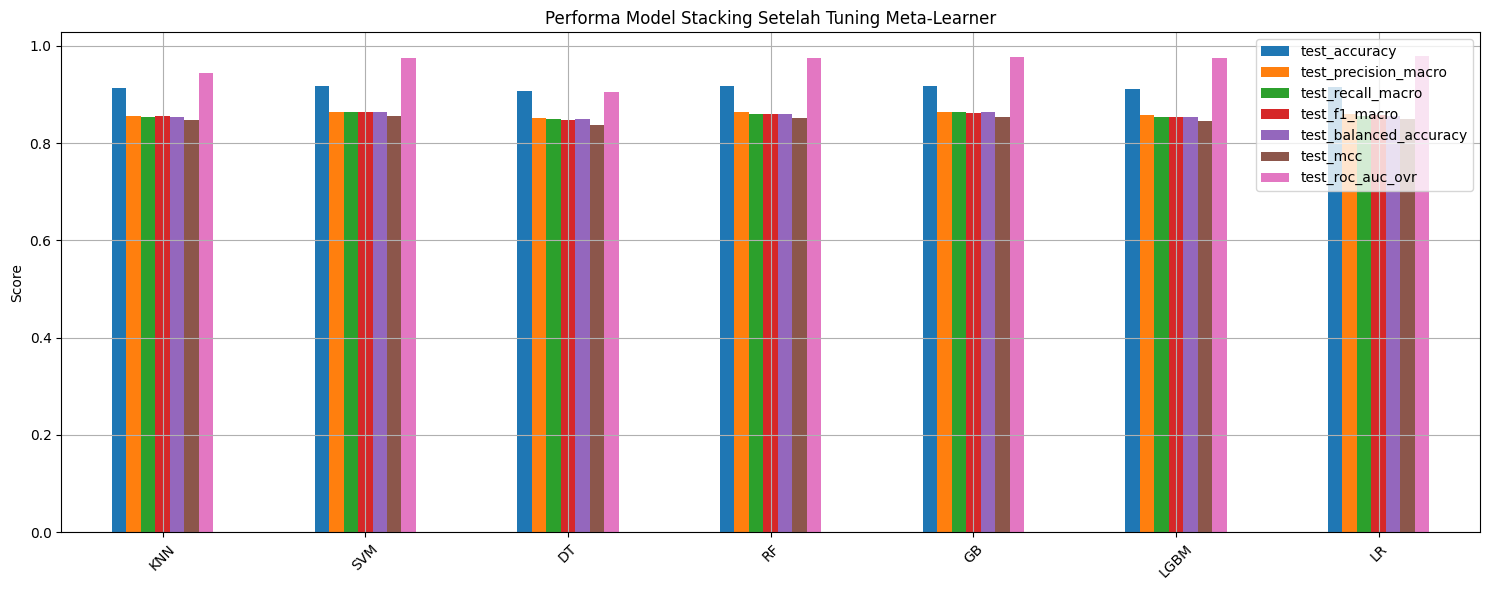

In [ ]:
# Iterate and display the evaluation scores for each model stacking after tuning

from sklearn.base import clone # Corrected import
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
import pickle
import os
import csv

# Evaluate the tuned stacking models
tuned_stacking_results = {}

for name, model in tuned_stacking_models.items():
    print(f"📊 Evaluating Tuned Stacking Model (Meta: {name})...")
    # Mutual info filtering needs to be applied consistently
    X_imp = IterativeImputer(random_state=42).fit_transform(X_trainval)
    mi_scores = mutual_info_classif(X_imp, y_trainval)
    selected_idx = np.where(mi_scores > 0)[0]

    # The pipeline saved includes the SelectKBest step with the number of features from the tuning
    # We can directly use the saved `tuned_stacking_models[name]` pipeline for evaluation

    scores = cross_validate(model, X_trainval.iloc[:, selected_idx], y_trainval, cv=cv, scoring=scoring)
    tuned_stacking_results[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring.keys()}

# Iterate and display the evaluation scores for each model stacking after tuning
print("\n=== Tuned Stacking Model Evaluation Results ===")
for name, scores in tuned_stacking_results.items():
    print(f"\n--- Stacking (Meta: {name}, Tuned) ---")
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")

# Plotting the results
df_tuned_stacking = pd.DataFrame(tuned_stacking_results).T
df_tuned_stacking.plot(kind='bar', figsize=(15, 6))
plt.title("Performa Model Stacking (Setelah Tuning Meta-Learner)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n✅ Evaluation of tuned stacking models complete.")

📊 Evaluating Tuned Stacking Model (Meta: KNN)...
📊 Evaluating Tuned Stacking Model (Meta: SVM)...
📊 Evaluating Tuned Stacking Model (Meta: DT)...
📊 Evaluating Tuned Stacking Model (Meta: RF)...
📊 Evaluating Tuned Stacking Model (Meta: GB)...
📊 Evaluating Tuned Stacking Model (Meta: LGBM)...
📊 Evaluating Tuned Stacking Model (Meta: LR)...

=== Tuned Stacking Model Evaluation Results ===

--- Stacking (Meta: KNN, Tuned) ---
accuracy: 0.9183
precision_macro: 0.8686
recall_macro: 0.8606
f1_macro: 0.8606
balanced_accuracy: 0.8606
mcc: 0.8559
roc_auc_ovr: 0.9488

--- Stacking (Meta: SVM, Tuned) ---
accuracy: 0.9198
precision_macro: 0.8678
recall_macro: 0.8658
f1_macro: 0.8644
balanced_accuracy: 0.8658
mcc: 0.8584
roc_auc_ovr: 0.9753

--- Stacking (Meta: DT, Tuned) ---
accuracy: 0.9183
precision_macro: 0.8653
recall_macro: 0.8658
f1_macro: 0.8642
balanced_accuracy: 0.8658
mcc: 0.8552
roc_auc_ovr: 0.9262

--- Stacking (Meta: RF, Tuned) ---
accuracy: 0.9139
precision_macro: 0.8629
recall_macro:

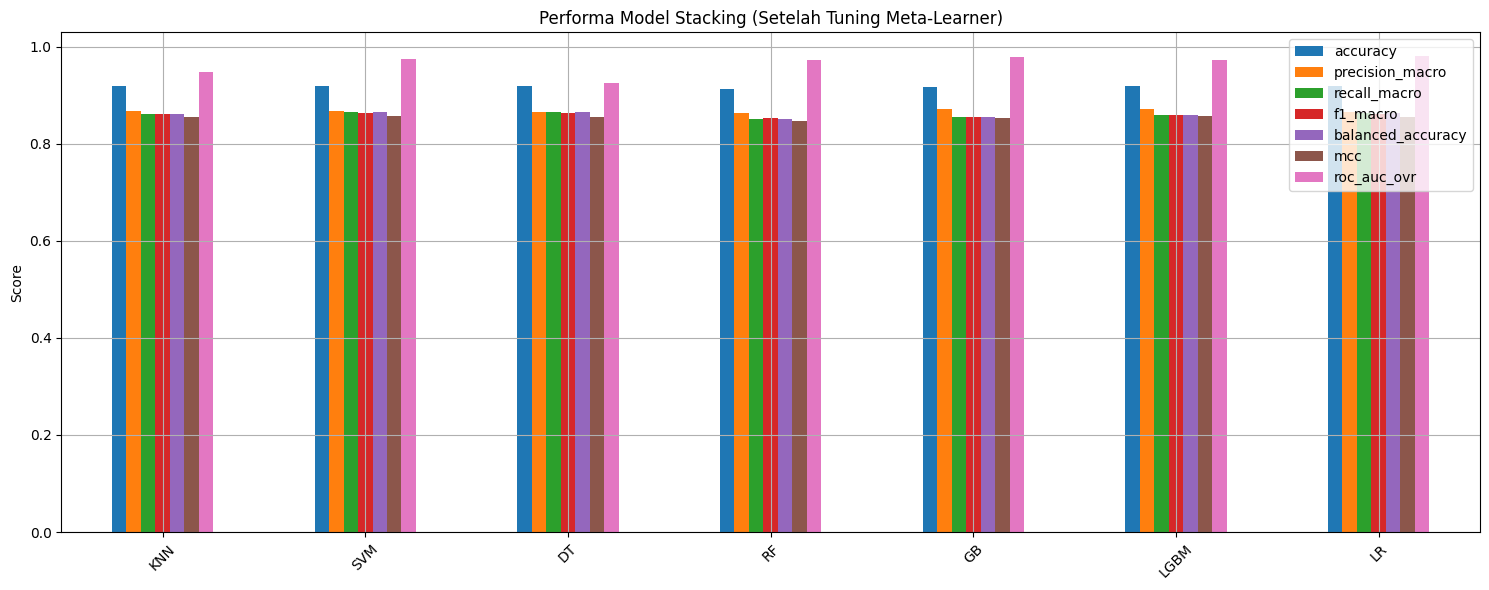


✅ Evaluation of tuned stacking models complete.


In [ ]:
# Iterate and display the evaluation scores for each model stacking after tuning

from sklearn.base import clone # Corrected import
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
import pickle
import os
import csv

# Evaluate the tuned stacking models
tuned_stacking_results = {}

for name, model in tuned_stacking_models.items():
    print(f"📊 Evaluating Tuned Stacking Model (Meta: {name})...")
    # Mutual info filtering needs to be applied consistently
    X_imp = IterativeImputer(random_state=42).fit_transform(X_trainval)
    mi_scores = mutual_info_classif(X_imp, y_trainval)
    selected_idx = np.where(mi_scores > 0)[0]

    # The pipeline saved includes the SelectKBest step with the number of features from the tuning
    # We can directly use the saved `tuned_stacking_models[name]` pipeline for evaluation

    scores = cross_validate(model, X_trainval.iloc[:, selected_idx], y_trainval, cv=cv, scoring=scoring)
    tuned_stacking_results[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring.keys()}

# Iterate and display the evaluation scores for each model stacking after tuning
print("\n=== Tuned Stacking Model Evaluation Results ===")
for name, scores in tuned_stacking_results.items():
    print(f"\n--- Stacking (Meta: {name}, Tuned) ---")
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")

# Plotting the results
df_tuned_stacking = pd.DataFrame(tuned_stacking_results).T
df_tuned_stacking.plot(kind='bar', figsize=(15, 6))
plt.title("Performa Model Stacking (Setelah Tuning Meta-Learner)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n✅ Evaluation of tuned stacking models complete.")

In [ ]:
# === Tuning Stacking Versi 2 (4 base estimators) ===

# Base estimators versi 2 (4 model)
base_estimators_4 = [
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('lgbm', lgb.LGBMClassifier())
]

# Folder simpan hasil versi 2
os.makedirs("stacking_models_v2", exist_ok=True)

tuned_stacking_models_v2 = {}
tuned_stacking_params_v2 = {}

for name, meta in meta_learners.items():
    print(f"\n🔧 Tuning Stacking Versi 2 (Meta: {name})...")

    stacking_v2 = StackingClassifier(
        estimators=base_estimators_4,
        final_estimator=meta,
        cv=5,
        n_jobs=-1
    )

    pipeline_v2 = ImbPipeline([
        ('imputer', IterativeImputer(random_state=42)),
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('select', SelectKBest(mutual_info_classif, k=X_trainval.shape[1])),
        ('stacking', stacking_v2)
    ])

    param_grid_v2 = meta_param_grids[name]

    grid_v2 = GridSearchCV(
        pipeline_v2,
        param_grid=param_grid_v2,
        scoring='f1_macro',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_v2.fit(X_trainval, y_trainval)

    best_model_v2 = grid_v2.best_estimator_
    best_params_v2 = grid_v2.best_params_

    # Simpan
    tuned_stacking_models_v2[name] = best_model_v2
    tuned_stacking_params_v2[name] = best_params_v2

    # Simpan model dan params
    with open(f"stacking_models_v2/stacking_tuned_{name}_v2.sav", "wb") as f:
        pickle.dump(best_model_v2, f)

    with open(f"stacking_models_v2/stacking_tuned_{name}_v2_params.csv", "w", newline='') as f:
        writer = csv.writer(f)
        for key, val in best_params_v2.items():
            writer.writerow([key, val])

    print(f"✅ Tuning Stacking V2 Selesai: {name} | Model & Params disimpan.")

# Evaluasi performa dari best model yang sudah di-tuning
scores = cross_validate(best_model, X_trainval, y_trainval, scoring=scoring, cv=5)
mean_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

print(f"\n📊 Cross-validation scores for {name} (tuned):")
for metric, score in mean_scores.items():
    print(f"{metric}: {score:.4f}")

df_stacked_tuned = pd.DataFrame({
    meta: cross_validate(model, X_trainval, y_trainval, scoring=scoring, cv=5)
    for meta, model in tuned_stacking_models.items()
}).applymap(lambda v: np.mean(v) if isinstance(v, np.ndarray) else v)

df_stacked_tuned.loc[[f'test_{k}' for k in scoring.keys()]].T.plot(kind='bar', figsize=(15,6))
plt.title("Performa Model Stacking Setelah Tuning Meta-Learner")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()

4 model terbaik sebagai base learner

📊 Evaluating Tuned Stacking 4 Model (Meta: KNN)...
📊 Evaluating Tuned Stacking 4 Model (Meta: SVM)...
📊 Evaluating Tuned Stacking 4 Model (Meta: DT)...
📊 Evaluating Tuned Stacking 4 Model (Meta: RF)...
📊 Evaluating Tuned Stacking 4 Model (Meta: GB)...
📊 Evaluating Tuned Stacking 4 Model (Meta: LGBM)...
📊 Evaluating Tuned Stacking 4 Model (Meta: LR)...

=== Tuned Stacking 4 Model Evaluation Results ===

--- Stacking 4 (Meta: KNN, Tuned) ---
accuracy: 0.9198
precision_macro: 0.8703
recall_macro: 0.8636
f1_macro: 0.8636
balanced_accuracy: 0.8636
mcc: 0.8583
roc_auc_ovr: 0.9552

--- Stacking 4 (Meta: SVM, Tuned) ---
accuracy: 0.9183
precision_macro: 0.8689
recall_macro: 0.8606
f1_macro: 0.8612
balanced_accuracy: 0.8606
mcc: 0.8558
roc_auc_ovr: 0.9712

--- Stacking 4 (Meta: DT, Tuned) ---
accuracy: 0.9079
precision_macro: 0.8503
recall_macro: 0.8413
f1_macro: 0.8421
balanced_accuracy: 0.8413
mcc: 0.8371
roc_auc_ovr: 0.9074

--- Stacking 4 (Meta: RF, Tuned) ---
accuracy: 0.9123
precision_mac

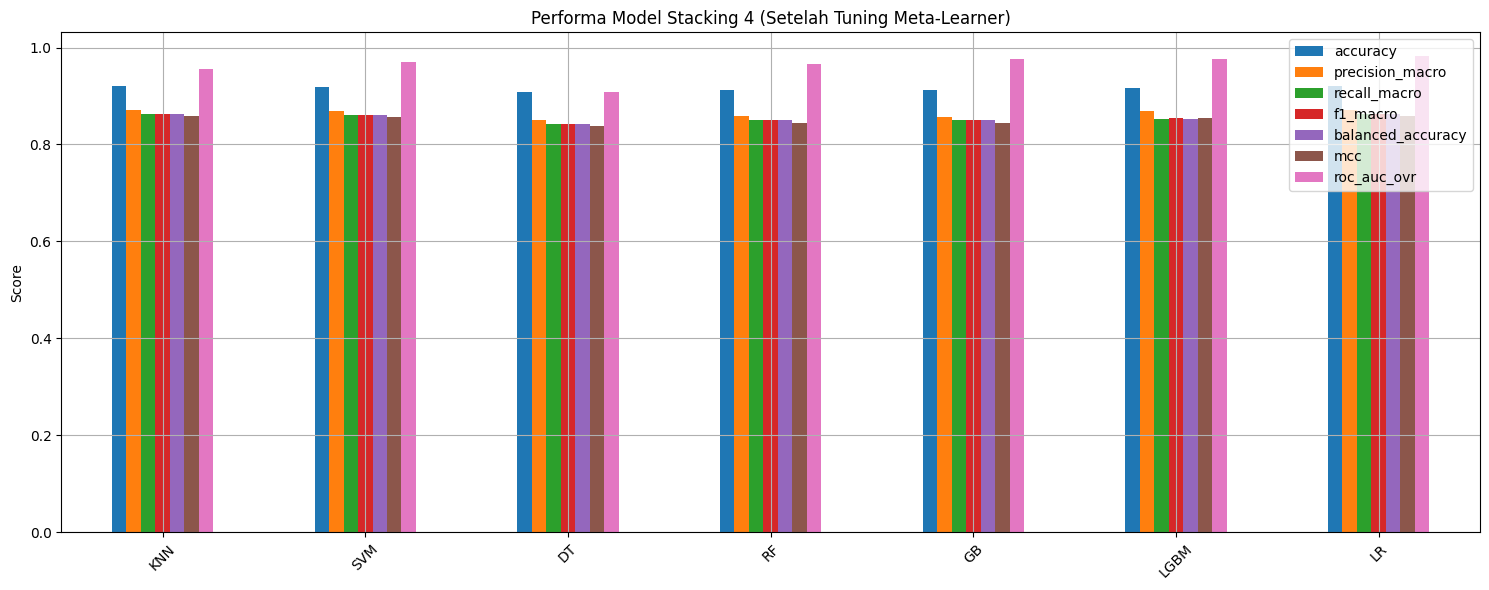


✅ Evaluation of tuned stacking 4 models complete.


In [ ]:
# Iterate and display the evaluation scores for each model stacking after tuning

from sklearn.base import clone # Corrected import
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
import pickle
import os
import csv

# Evaluate the tuned stacking models
tuned_stacking_4_results = {}

for name, model in tuned_stacking_4_models.items():
    print(f"📊 Evaluating Tuned Stacking 4 Model (Meta: {name})...")
    # Mutual info filtering needs to be applied consistently
    X_imp = IterativeImputer(random_state=42).fit_transform(X_trainval)
    mi_scores = mutual_info_classif(X_imp, y_trainval)
    selected_idx = np.where(mi_scores > 0)[0]

    # The pipeline saved includes the SelectKBest step with the number of features from the tuning
    # We can directly use the saved `tuned_stacking_models[name]` pipeline for evaluation

    scores = cross_validate(model, X_trainval.iloc[:, selected_idx], y_trainval, cv=cv, scoring=scoring)
    tuned_stacking_4_results[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring.keys()}

# Iterate and display the evaluation scores for each model stacking after tuning
print("\n=== Tuned Stacking 4 Model Evaluation Results ===")
for name, scores in tuned_stacking_4_results.items():
    print(f"\n--- Stacking 4 (Meta: {name}, Tuned) ---")
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")

# Plotting the results
df_tuned_stacking_4 = pd.DataFrame(tuned_stacking_4_results).T
df_tuned_stacking_4.plot(kind='bar', figsize=(15, 6))
plt.title("Performa Model Stacking 4 (Setelah Tuning Meta-Learner)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n✅ Evaluation of tuned stacking 4 models complete.")

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score, matthews_corrcoef
)
import os
import pickle
import pandas as pd

# Path ke folder model stacking yang sudah dituning
stacking_folder = "stacking_models"
meta_learners = ['KNN', 'SVM', 'DT', 'RF', 'GB', 'LGBM', 'LR']

# Inisialisasi dataframe hasil
results = []

# Evaluasi masing-masing model stacking
for meta in meta_learners:
    model_path = os.path.join(stacking_folder, f"stacking_tuned_{meta}.sav")

    if not os.path.exists(model_path):
        print(f"⚠️ Model {meta} tidak ditemukan, lewati.")
        continue

    with open(model_path, "rb") as f:
        model = pickle.load(f)

    # Prediksi di data uji
    y_pred = model.predict(X_test)
    y_prob = None
    try:
        y_prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
    except:
        roc_auc = float('nan')

    # Hitung metrik
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Simpan ke hasil
    results.append({
        "Model": f"Stacking (Meta={meta})",
        "Precision (macro)": round(precision, 4),
        "Recall (macro)": round(recall, 4),
        "F1-score (macro)": round(f1, 4),
        "Accuracy": round(acc, 4),
        "Balanced Accuracy": round(balanced_acc, 4),
        "ROC AUC (macro)": round(roc_auc, 4),
        "MCC": round(mcc, 4)
    })

# Tampilkan hasil dalam tabel
df_results = pd.DataFrame(results)
print("\n--- 🔍 Hasil Evaluasi Model Stacking (Setelah Tuning) ---")
print(df_results)

# Opsional: Simpan ke CSV
df_results.to_csv("stacking_tuned_evaluation_summary.csv", index=False)



--- 🔍 Hasil Evaluasi Model Stacking (Setelah Tuning) ---
                  Model  Precision (macro)  Recall (macro)  F1-score (macro)  \
0   Stacking (Meta=KNN)             0.8992          0.8927            0.8958   
1   Stacking (Meta=SVM)             0.8716          0.8693            0.8704   
2    Stacking (Meta=DT)             0.8480          0.8364            0.8417   
3    Stacking (Meta=RF)             0.8982          0.8917            0.8944   
4    Stacking (Meta=GB)             0.8886          0.8846            0.8866   
5  Stacking (Meta=LGBM)             0.8886          0.8846            0.8866   
6    Stacking (Meta=LR)             0.8988          0.8965            0.8974   

   Accuracy  Balanced Accuracy  ROC AUC (macro)     MCC  
0    0.9349             0.8927           0.9534  0.8841  
1    0.9172             0.8693           0.9804  0.8529  
2    0.8994             0.8364           0.9072  0.8200  
3    0.9349             0.8917           0.9730  0.8842  
4    0.9290

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score, matthews_corrcoef
)
import os
import pickle
import pandas as pd

# Path ke folder model stacking yang sudah dituning
stacking_folder = "stacking_models_v2"
meta_learners = ['KNN', 'SVM', 'DT', 'RF', 'GB', 'LGBM', 'LR']

# Inisialisasi dataframe hasil
results = []

# Evaluasi masing-masing model stacking
for meta in meta_learners:
    model_path = os.path.join(stacking_folder, f"stacking_tuned_{meta}_v2.sav")

    if not os.path.exists(model_path):
        print(f"⚠️ Model {meta} tidak ditemukan, lewati.")
        continue

    with open(model_path, "rb") as f:
        model = pickle.load(f)

    # Prediksi di data uji
    y_pred = model.predict(X_test)
    y_prob = None
    try:
        y_prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
    except:
        roc_auc = float('nan')

    # Hitung metrik
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Simpan ke hasil
    results.append({
        "Model": f"Stacking (Meta={meta})",
        "Precision (macro)": round(precision, 4),
        "Recall (macro)": round(recall, 4),
        "F1-score (macro)": round(f1, 4),
        "Accuracy": round(acc, 4),
        "Balanced Accuracy": round(balanced_acc, 4),
        "ROC AUC (macro)": round(roc_auc, 4),
        "MCC": round(mcc, 4)
    })

# Tampilkan hasil dalam tabel
df_results = pd.DataFrame(results)
print("\n--- 🔍 Hasil Evaluasi Model Stacking (Setelah Tuning) ---")
print(df_results)

# Opsional: Simpan ke CSV
df_results.to_csv("stacking_tuned_evaluation_summary.csv", index=False)



--- 🔍 Hasil Evaluasi Model Stacking (Setelah Tuning) ---
                  Model  Precision (macro)  Recall (macro)  F1-score (macro)  \
0   Stacking (Meta=KNN)             0.8894          0.8894            0.8894   
1   Stacking (Meta=SVM)             0.8894          0.8894            0.8894   
2    Stacking (Meta=DT)             0.8626          0.8489            0.8549   
3    Stacking (Meta=RF)             0.9013          0.8889            0.8941   
4    Stacking (Meta=GB)             0.9004          0.8841            0.8914   
5  Stacking (Meta=LGBM)             0.9217          0.9042            0.9120   
6    Stacking (Meta=LR)             0.8992          0.8927            0.8958   

   Accuracy  Balanced Accuracy  ROC AUC (macro)     MCC  
0    0.9290             0.8894           0.9431  0.8740  
1    0.9290             0.8894           0.9446  0.8740  
2    0.9112             0.8489           0.9023  0.8414  
3    0.9349             0.8889           0.9810  0.8842  
4    0.9349